In [16]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [17]:
from fastai.vision import *

In [18]:
bs = 64

In [19]:
path = untar_data(URLs.PETS)/'images'

In [20]:
tfms = get_transforms(max_rotate=20, max_zoom=1.3, max_lighting=0.4, max_warp=0.4, 
                     p_affine=1., p_lighting=1.)

In [21]:
doc(get_transforms)

In [22]:
src = ImageList.from_folder(path).split_by_rand_pct(0.2, seed=2)

In [23]:
def get_data(size, bs, padding_mode='reflection'):
    return (src.label_from_re(r'([^/]+)_\d+.jpg$')
            .transform(tfms, size=size, padding_mode=padding_mode)
            .databunch(bs=bs).normalize(imagenet_stats))

In [24]:
data = get_data(224, bs, 'zeros')

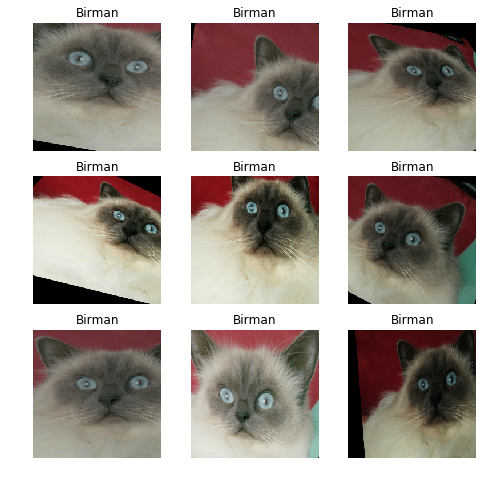

In [25]:
def _plot(i, j, ax):
    x, y = data.train_ds[33]
    x.show(ax, y=y)
    
plot_multi(_plot, 3, 3, figsize=(8, 8))

In [26]:
data = get_data(224, bs)

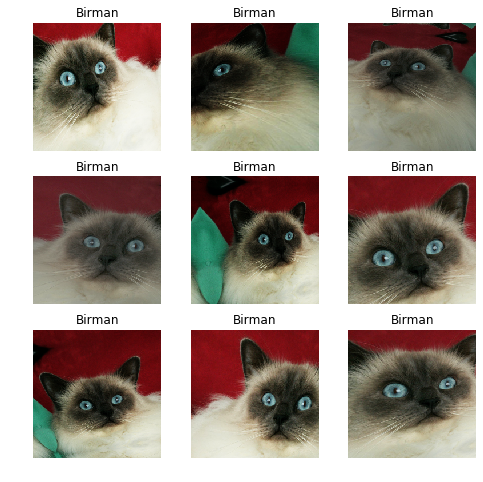

In [27]:
plot_multi(_plot, 3, 3, figsize=(8, 8))

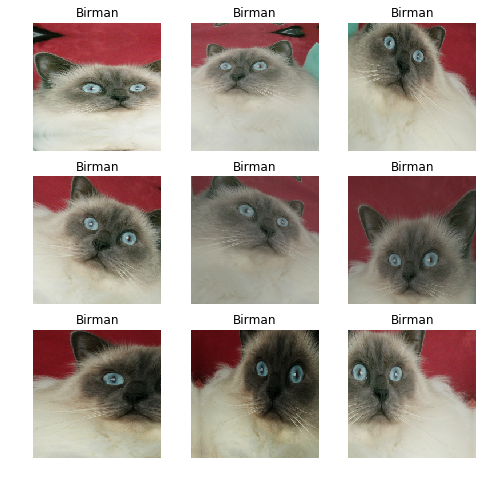

In [28]:
plot_multi(_plot, 3, 3, figsize=(8, 8))

In [29]:
gc.collect()

14586

In [31]:
learn = cnn_learner(data, models.resnet34, metrics=error_rate, bn_final=True)

In [ ]:
learn.fit_one_cycle(3, slice(1e-2), pct_start=0.8)

epoch,train_loss,valid_loss,error_rate,time
0,2.478914,1.290139,0.281461,11:10
1,1.453614,0.367625,0.091340,11:02


In [ ]:
learn.unfreeze()

In [ ]:
learn.fit_one_cycle(2, max_lr=slice(1e-6, 1e-3), pct_start=0.8)

In [ ]:
data = get_data(352, bs)
learn.data = data

In [ ]:
learn.fit_one_cycle(2, max_lr=slice(1e-6, 1e-4))

In [ ]:
learn.save('352')

## Convolution Kernet

In [ ]:
data = get_data(352, 16)

In [ ]:
learn = cnn_learner(data, models.resnet34, metrics=error_rate, bs_final=True).load('352')

In [ ]:
idx = 0
x, y = data.valid_ds[idx]
x.show()
data.valid_ds.y[idx]

In [ ]:
k = tensor([
    [0., -5/3, 1], 
    [-5/3, -5/3, 1], 
    [1., 1, 1],     
]).expand(1, 3, 3, 3)/6

In [ ]:
k

In [ ]:
k.shape

In [ ]:
t = data.valid_ds[0][0].data; t.shape

In [ ]:
t[None].shape

In [ ]:
edge = F.conv2d(t[None], k)

In [ ]:
show_image(edge[0], figsize=(5, 5));

In [ ]:
data.c

In [ ]:
learn.model

In [ ]:
print(learn.summary())

## Heatmap

In [ ]:
m = learn.model.eval();

In [ ]:
xb, _ = data.one_item(x)
xb_im = Image(data, denorm(xb)[0])
xb = xb.cuda()

In [ ]:
from fastai.callbacks.hooks import *

In [ ]:
def hooked_backward(cat=y):
    with hook_output(m[0]) as hooka:
        with hook_output(m[0], grad=True) as hook_g:
            preds = m(xb)
            preds[0, int(cat)].backware()
    return hook_a, hook_g

In [ ]:
hook_a, hook_g = hooked_backward()

In [ ]:
acts = hook_a.stored[0].cpu()
acts.shape

In [ ]:
acv_acts = acts.mean(0)
avg_acts.shape

In [ ]:
def show_heatmap(hm):
    _, ax = plt.subplots()
    xb_im.show(ax)
    ax.imshow(hm, alpha=0.6, extent=(0, 352, 352, 0), 
             interpolation='bilinear', cmap='magma');

In [ ]:
show_heatmap(avg_acts)

## Grad-CAM

In [ ]:
grad = hook_g.stored[0][0].cpu()
grad_chan = grad.mean(1).mean(1)
grad.shape, grad_chan.shape

In [ ]:
mult = (acts*grad_chan[..., None, None]).mean(0)

In [ ]:
show_heatmap(mult)

In [ ]:
# replace with your image
fn = path/'../other/bulldog_maine.jpg' 

In [ ]:
x = open_image(fn); x

In [ ]:
xb, _ = data.one_item(x)
xb_im = Image(data.denorm(xb)[0])
xb = xb.cuda()

In [ ]:
hook_a, hook_g = hooked_backward()

In [ ]:
acts = hook_a.stored[0].cpu()
grad = hook_g.stored[0][0].cpu()

grad_chan = grad.mean(1).mean(1)
mult = (acts*grad_chan[..., None, None]).mean(0)

In [ ]:
show_heatmap(mult)

In [ ]:
data.classes[0]

In [ ]:
hook_a, hook_g = hooked_backward(0)

In [ ]:
acts = hook_a.stored[0].cpu()
grad = hook_g.stored[0][0].cpu()

grad_chan = grad.mean(1).mean(1)
mult = (acts*grad_chan[..., None, None]).mean(0)

In [ ]:
show_heatmap(mult)